In [9]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt

from constants import SAMPLE_LENGTH

In [10]:
# Specify train or test directories for data generation
which_dir = "test"

In [11]:
# Directory paths
data_dir = f"raw_{which_dir}_data"
dataset_dir = "animation_dataset"
figures_dir = "figures"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(figures_dir, exist_ok=True)

In [12]:
# Specify which directory to generate data for
save_dir = train_dir if which_dir == "train" else test_dir
samples_dir = os.path.join(save_dir, "samples")
os.makedirs(samples_dir, exist_ok=True)

In [13]:
# Data cleaner
# Collect all file paths
files = [f for f in os.listdir(data_dir) if f.endswith(".txt")]
df_lengths = []
sample_info_df = pd.DataFrame(columns=["effect_name", "start_timestamp"])
for file in files:
    file_path = os.path.join(data_dir, file)

    # Read the CSV
    df = pd.read_csv(file_path, parse_dates=["timestamp"])

    # Strip whitespace from column names
    df.columns = df.columns.str.strip()

    # Strip whitespace from string entries (if any)
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].str.strip()

    # Convert timestamp to elapsed time in seconds
    start_timestamp = df["timestamp"].iloc[0]
    df["time_s"] = (df["timestamp"] - start_timestamp).dt.total_seconds()
    df = df.drop(columns=["timestamp"])

    num_frames = len(df)
    df_lengths.append(num_frames)

    # Split the dataframe into samples of same length and save
    cur_start = 0
    num_samples = 1
    while cur_start < num_frames:
        # File path
        timestamp_str = str(start_timestamp)
        filename = file.split(".")[1].split("_")[0] + "_" + timestamp_str + "_" + str(num_samples)
        save_path = os.path.join(samples_dir, f"{filename}.csv")

        cur_df = (df[cur_start:cur_start + SAMPLE_LENGTH]).astype("float32")
        if len(cur_df) == SAMPLE_LENGTH:
            # Save DataFrame
            cur_df.to_csv(save_path, index=False)

            # Save information about sample
            effect_name, sample_number, snippet_number = filename.split("_")
            sample_info = {"effect_name": effect_name, "start_timestamp": timestamp_str, "snippet_number": snippet_number}
            sample_info_df = pd.concat([sample_info_df, pd.DataFrame([sample_info])], ignore_index=True)

        cur_start += SAMPLE_LENGTH
        num_samples += 1

In [14]:
print(f"Loaded {len(sample_info_df)} samples from {len(files)} files.")

Loaded 7 samples from 3 files.


In [15]:
sample_info_df.to_csv(os.path.join(save_dir, "dataset_info.csv"), index=True)

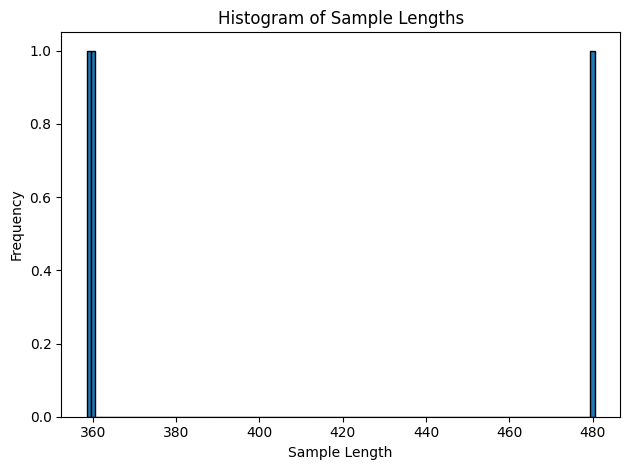

In [16]:
# Plot lengths of samples
plt.hist(df_lengths, bins=range(min(df_lengths), max(df_lengths) + 2), edgecolor="black", align="left")

plt.xlabel("Sample Length")
plt.ylabel("Frequency")
plt.title("Histogram of Sample Lengths")

plt.tight_layout()
plt.savefig(
    os.path.join(figures_dir, "sample_lengths.pdf"),
    bbox_inches="tight"
)